In [1]:
#Download the SDSS quasar data
#Upsample this distribution in hopefully two ways (but at least one of them), using
#both rejection sampling and inverse transform.
#Think about the cosmology of quasars. How do you think they are distributed?
#Overplot the theorethical distribution to the measured SDSS data. Does that agree
#with your expectation?

In [2]:
from astropy.cosmology import Planck18
from astroML.datasets import fetch_dr7_quasar
import scipy.stats
import scipy.interpolate
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ks_2samp


In [3]:
#Fetch the first n_samples from the SDSS quasar redshift dataset
def fetch_data(n_samples=10000):
    quasars = fetch_dr7_quasar()
    return quasars['redshift'][:n_samples]

redshifts = fetch_data()

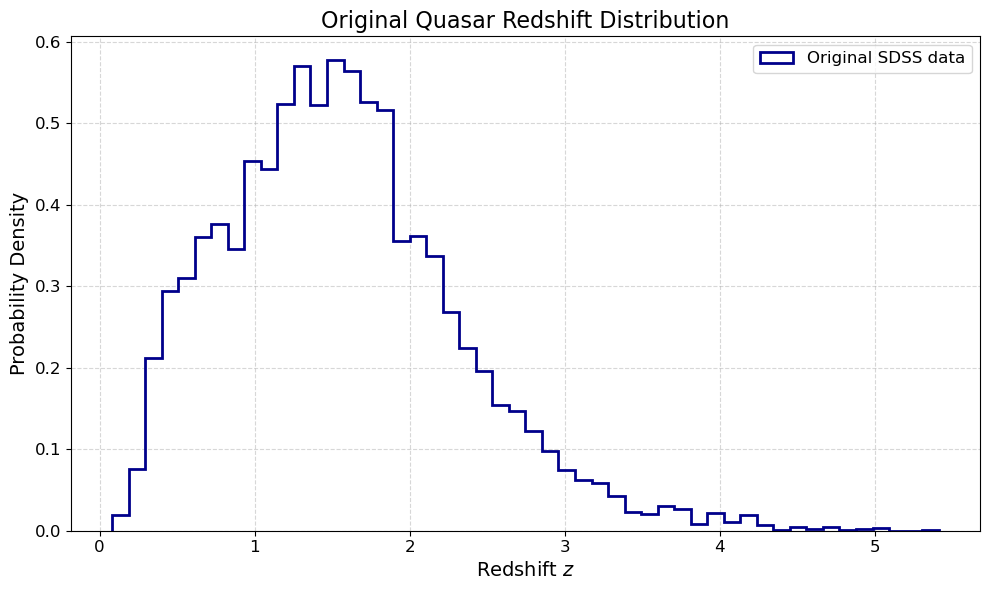

In [4]:
#Normalized histogram
def plot_histogram(data, bins=50, label='Data', title='',
                   color='black', linestyle='-', linewidth=2):
    plt.hist(data, bins=bins, density=True, histtype='step',
             label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    plt.xlabel('Redshift $z$', fontsize=14)
    plt.ylabel('Probability Density', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=12)

# Original data plot
plt.figure(figsize=(10, 6))
plot_histogram(redshifts, label='Original SDSS data',
            title='Original Quasar Redshift Distribution',
            color='darkblue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

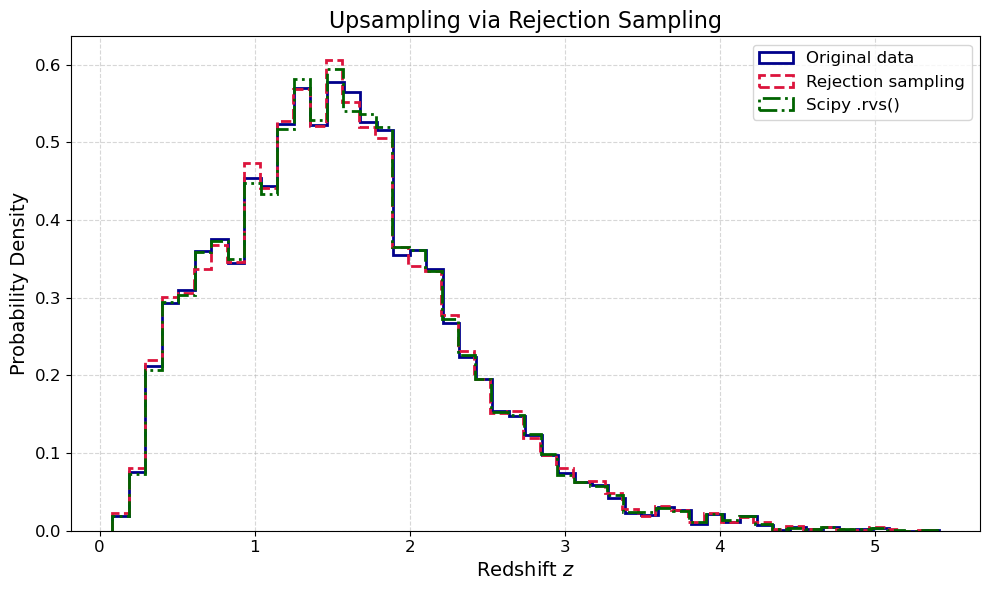

In [5]:


#rejection sampling
def rejection_sampling(data, n_trials=100000):
    """Perform rejection sampling based on a histogram approximation."""
    counts, bins = np.histogram(data, bins=50, density=True)
    maxh = counts.max()
    disth = scipy.stats.rv_histogram((counts, bins))
    q = np.random.uniform(min(bins), max(bins), n_trials)
    u = np.random.uniform(0, maxh, n_trials)
    mask = u <= disth.pdf(q)
    samples_manual = q[mask]
    samples_scipy = disth.rvs(size=n_trials)
    return samples_manual, samples_scipy

# Rejection sampling
samples_reject, samples_scipy = rejection_sampling(redshifts)
plt.figure(figsize=(10, 6))
plot_histogram(redshifts, label='Original data', color='darkblue')
plot_histogram(samples_reject, label='Rejection sampling',
                color='crimson', linestyle='--')
plot_histogram(samples_scipy, label='Scipy .rvs()',
                color='darkgreen', linestyle='-.')
plt.title('Upsampling via Rejection Sampling', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


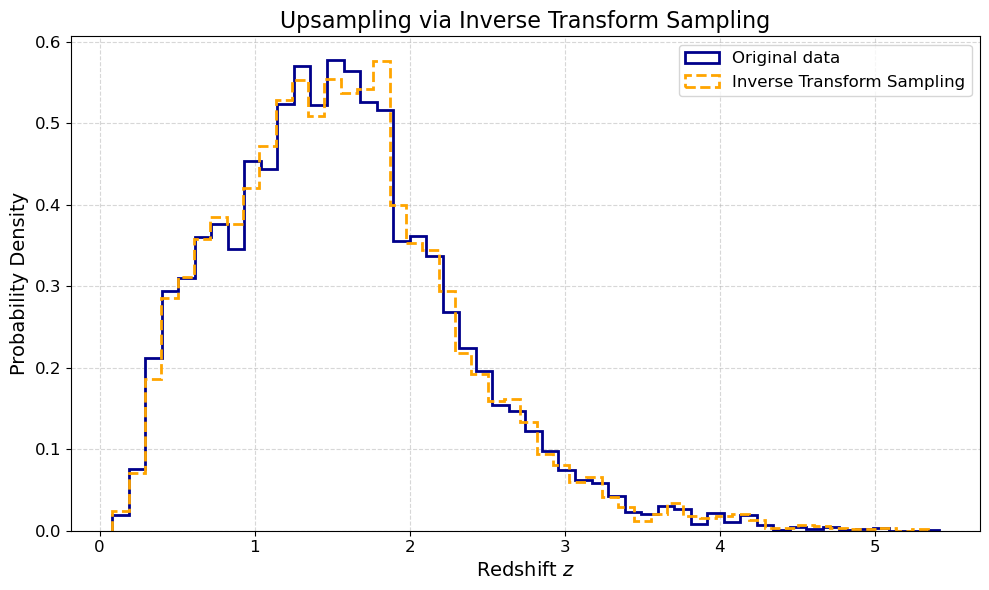

In [6]:


#inverse transform sampling
def inverse_transform_sampling(data, n_samples=10000):
    """Perform inverse transform sampling from the histogram CDF"""
    counts, bins = np.histogram(data, bins=50, density=True)

    # probability mass per bin = density * bin width
    widths = np.diff(bins)
    pmass = counts * widths

    # cumulative distribution defined on bin edges
    cdf = np.concatenate([[0.0], np.cumsum(pmass)])
    cdf = cdf / cdf[-1]  # normalize to 1

    # invert the CDF: interpolate between edges and CDF values
    inv_cdf = scipy.interpolate.interp1d(
        cdf, bins, kind='linear', bounds_error=True
    )

    # draw uniform samples in [0,1] and map them through the inverse CDF
    u = np.random.uniform(0.0, 1.0, n_samples)
    return inv_cdf(u)

# Inverse transform
samples_inverse = inverse_transform_sampling(redshifts)
plt.figure(figsize=(10, 6))
plot_histogram(redshifts, label='Original data', color='darkblue')
plot_histogram(samples_inverse,
                label='Inverse Transform Sampling',
                color='orange', linestyle='--')
plt.title('Upsampling via Inverse Transform Sampling', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


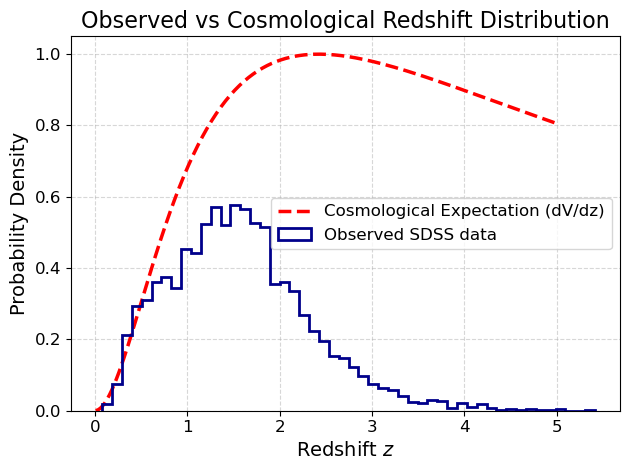

In [7]:


#Compare redshift distribution with the differential comoving volume
def plot_cosmological_expectation(z_data, z_range=(0.01, 5), n_points=200):
    z_vals = np.linspace(z_range[0], z_range[1], n_points)
    dV_dz = Planck18.differential_comoving_volume(z_vals).value
    dV_dz_norm = dV_dz / np.max(dV_dz)

    plt.plot(z_vals, dV_dz_norm, 'r--', linewidth=2.5,
             label='Cosmological Expectation (dV/dz)')
    plot_histogram(z_data, label='Observed SDSS data',
                   color='darkblue', linewidth=2)

    plt.title('Observed vs Cosmological Redshift Distribution', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Cosmological model vs observation
plot_cosmological_expectation(redshifts)


In [8]:

#TWO-SAMPLE KS (Kologorov-Smirnov) TEST: observed vs cloned distributions (quantitative check)
def ks_report(observed, *samples, labels=None):
    if labels is None:
        labels = [f"sample_{i+1}" for i in range(len(samples))]
    for s, lab in zip(samples, labels):
        D, p = ks_2samp(observed, s)
        print(f"[KS] {lab} vs observed: D = {D:.4f}, p = {p:.3g}")

#Quantitative checks
# KS test: observed vs cloned samples
ks_report(redshifts,
        samples_reject, samples_inverse, samples_scipy,
        labels=["rejection", "inverse", "scipy"])


[KS] rejection vs observed: D = 0.0086, p = 0.616
[KS] inverse vs observed: D = 0.0078, p = 0.921
[KS] scipy vs observed: D = 0.0047, p = 0.986
